In [1]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

# План лекции
 * bias-variance tradeoff
 * композиции алгоритмов (in general)
 * bootstrap
 * bagging
 * RSM (random subsampling method)
 * RandomForest
   * алгоритм
   * важности признаков
 * boosting
   * Adaboost
 * Blending, stacking

# Bias variance tradeoff

  $Bias[f'(x)] = E[f'(x) - f(x)]$<br>
$Var[f'(x)] = E[f'(x)^2] - (E[f'(x)])^2$<br>


$E[(f(x) - f'(x))^2] = (Bias[f'(x)])^2 + Var[f'(x)] + \sigma^2$

# Ансамбли моделей

### Мудрость толпы
Если спросить много людей о некоторой характеристике и усреднить- получится результат лучше, чем полученный от одного
эксперта.
В онлайне зармещена картинка с коровой. Люди заходят на сайт и дают оценку её веса. Средний результат их 17000
предсказаний отклоняется от действительного значение на 5%.

## Voting Classifiers

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

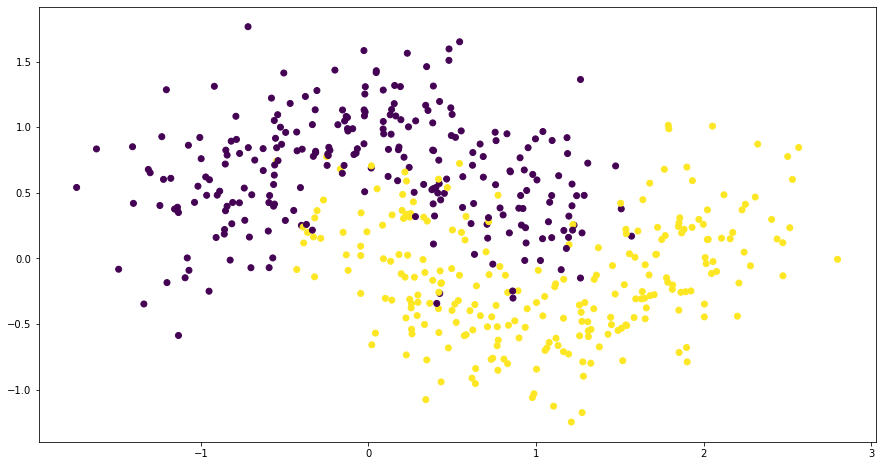

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=y)

### Hard Voting
Посмтроим несколькот моделей на одних и тех же данных.
Предсказание будем делать всеми миоделямиб в результате предсказания выберем тот класс, за который проголосует
большинство моделей - **hard voting**

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


### Soft voting 
Если все классификаторы могут вернуть вероятность (реализован метод predict proba), то можем посчитать среднее - **soft-voting**

In [6]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


In [8]:
voting_clf.predict_proba(X_test)

array([[0.51627522, 0.48372478],
       [0.75554677, 0.24445323],
       [0.68916396, 0.31083604],
       [0.019421  , 0.980579  ],
       [0.06317928, 0.93682072],
       [0.11442562, 0.88557438],
       [0.98184223, 0.01815777],
       [0.97614735, 0.02385265],
       [0.67591976, 0.32408024],
       [0.96789922, 0.03210078],
       [0.01266336, 0.98733664],
       [0.9817691 , 0.0182309 ],
       [0.07838561, 0.92161439],
       [0.17607193, 0.82392807],
       [0.04381091, 0.95618909],
       [0.93950502, 0.06049498],
       [0.97581198, 0.02418802],
       [0.03742245, 0.96257755],
       [0.14783905, 0.85216095],
       [0.92762252, 0.07237748],
       [0.94099766, 0.05900234],
       [0.14850351, 0.85149649],
       [0.47582201, 0.52417799],
       [0.85391568, 0.14608432],
       [0.90187943, 0.09812057],
       [0.84527399, 0.15472601],
       [0.17452087, 0.82547913],
       [0.98250382, 0.01749618],
       [0.04136213, 0.95863787],
       [0.97167451, 0.02832549],
       [0.

На и ирисах:

In [9]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [10]:
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
    voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print('Accuracy %0.3f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

Accuracy 0.953 (+/- 0.04) [Logistic Regression]
Accuracy 0.940 (+/- 0.04) [Random Forest]
Accuracy 0.913 (+/- 0.04) [naive Bayes]
Accuracy 0.953 (+/- 0.04) [Ensemble]


In [11]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0,2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[1, 1, 1])

clf1 = clf1.fit(X,y)
clf2 = clf2.fit(X,y)
clf3 = clf3.fit(X,y)
eclf = eclf.fit(X,y)


for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.927 (+/- 0.07) [Logistic Regression]
Accuracy: 0.940 (+/- 0.04) [Random Forest]
Accuracy: 0.947 (+/- 0.03) [naive Bayes]
Accuracy: 0.940 (+/- 0.06) [Ensemble]


### Подбор параметров

In [12]:
from sklearn.model_selection import GridSearchCV

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')

params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200],}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid = grid.fit(iris.data, iris.target)

C:\Users\adwiz\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\adwiz\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [13]:
grid.best_estimator_

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=1)),
                             ('gnb', GaussianNB())],
                 voting='soft')

### Bootstrap
$N$ раз выбираем элементы с повторением из выборки. Сгенерируем $M$ подвыборок $X_1,X_2,...X_m$. По каждой из данных выборок мы можем оценивать различные статистики.

(array([ 4.,  2.,  8., 10., 20., 15., 58., 63., 31., 25., 18.,  8., 11.,
        10.,  1.,  3., 10.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.]),
 array([-2.09020668, -1.73665358, -1.38310049, -1.02954739, -0.67599429,
        -0.32244119,  0.0311119 ,  0.384665  ,  0.7382181 ,  1.0917712 ,
         1.44532429,  1.79887739,  2.15243049,  2.50598359,  2.85953668,
         3.21308978,  3.56664288,  3.92019598,  4.27374907,  4.62730217,
         4.98085527,  5.33440837,  5.68796146,  6.04151456,  6.39506766,
         6.74862076]),
 [<matplotlib.patches.Polygon at 0x233b3a7ef70>])

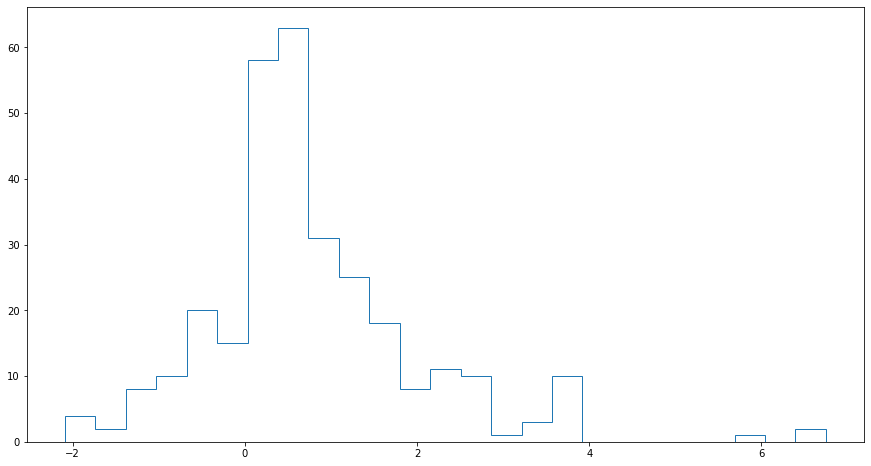

In [14]:
# 95% доверительный интервал для средней датасета

x = np.concatenate([np.random.exponential(size=200), np.random.normal(size=100)])
plt.hist(x, 25, histtype='step')

In [15]:
n = len(x)
reps = 10000
xb = np.random.choice(x, (n, reps))
mb = xb.mean(axis=0)
mb.sort()
np.percentile(mb, [2.5, 97.5])

array([0.63567509, 0.91312301])

# Bagging - bootstrap aggregation

Из выборки делаем сэмпл. Сэмплирование делаем с возвращением.

In [16]:
def subsample(data, ratio=1.4):
    return np.random.choice(data, size=int(data.shape[0] * ratio), replace=True)

In [17]:
dataset = np.random.randint(0, 1000, size=1000)

In [18]:
dataset

array([689, 815, 942,  24, 901, 575, 783,   4, 285, 997, 436, 593, 496,
       812, 329, 535, 238, 708, 718, 197, 422, 664, 682, 238, 567,  47,
       778, 880, 161, 792,  12, 962, 335, 834, 200, 362, 351, 770, 238,
       281,  53,  89, 403, 273, 110, 787, 289, 429, 287, 799, 636, 847,
        97, 667, 132, 585, 715,  37,  48, 949,  92, 937, 950, 671, 642,
       990, 457, 964, 934, 363, 855, 735, 429, 305, 141, 725, 222, 618,
       161, 659, 874, 618,  55, 489, 628, 920, 929, 415,  44, 579, 890,
       837, 964, 829, 518, 410, 570, 965, 200, 672, 718, 864, 817, 468,
       779,   2,  22, 847, 600, 276, 104, 340,  65, 735, 876, 519, 621,
       861, 759, 176, 428,  64, 196,  88, 351, 160, 952, 241, 756, 549,
       679, 108, 217, 745, 721, 106, 683, 226, 123, 886, 876, 477, 230,
       882, 932, 716, 448, 753, 739, 874, 110, 606, 572,  79, 924, 476,
       664, 625, 135, 992, 834, 284, 733, 586, 555, 520, 688, 332, 792,
       558, 145, 333, 539, 728,  19, 272, 900, 459, 268, 358, 35

In [19]:
print(np.unique(np.bincount(dataset)))

[0 1 2 3 4 5]


In [20]:
sample = subsample(dataset, ratio=0.4)

In [21]:
print(sample)

[776 684 348 292  41 836 273 575 829 745 641 976 411 460 732 341 778  37
 847 495 639 987 824 110  92 835 120 158   5 679 506 976 393 401 497 489
 401 192 963 835 277 382 170 403 655  41 525 970 238 993 960  58 837  34
 578 159 261 151 660 287  38  97 337 338 624 600  24 992 438  86 497 519
 666 117  43 279 539 631 420 673 280 411 269 828 351 626 145  74 627 242
 987 799 549 871 784 415 779 161 584 237 199 401 817 641 900 270 440 215
 239 238 765  34 468 549 353 713 283 733 302 598 803  35 261 196 255 522
 477 567  67 572 756 422 773 382 459 981 878 344  76 495 732 621 803 643
 960  24 237  95 487 606 528 217  37 540 404 428 766 161 651 222 267 943
 570 225 169 900 546 827  67 140 717 725   2 145 647 868 404 981 507 917
 579 495 222 169 153 994 759 496 665 717 574 352 598  95 895 745 920 507
 183 631 775 382  73 517  83 618 803 436 716 101 651 965 425 354 776 838
 153 352 383  99 533 517  75 420 563 780 261 938 238 268 650 358 162 167
 695 428 738 352 628  34 404 805 299 863 945 486  3

In [22]:
print(np.unique(np.bincount(sample)))

[0 1 2 3 4 5]


In [23]:
sample

array([776, 684, 348, 292,  41, 836, 273, 575, 829, 745, 641, 976, 411,
       460, 732, 341, 778,  37, 847, 495, 639, 987, 824, 110,  92, 835,
       120, 158,   5, 679, 506, 976, 393, 401, 497, 489, 401, 192, 963,
       835, 277, 382, 170, 403, 655,  41, 525, 970, 238, 993, 960,  58,
       837,  34, 578, 159, 261, 151, 660, 287,  38,  97, 337, 338, 624,
       600,  24, 992, 438,  86, 497, 519, 666, 117,  43, 279, 539, 631,
       420, 673, 280, 411, 269, 828, 351, 626, 145,  74, 627, 242, 987,
       799, 549, 871, 784, 415, 779, 161, 584, 237, 199, 401, 817, 641,
       900, 270, 440, 215, 239, 238, 765,  34, 468, 549, 353, 713, 283,
       733, 302, 598, 803,  35, 261, 196, 255, 522, 477, 567,  67, 572,
       756, 422, 773, 382, 459, 981, 878, 344,  76, 495, 732, 621, 803,
       643, 960,  24, 237,  95, 487, 606, 528, 217,  37, 540, 404, 428,
       766, 161, 651, 222, 267, 943, 570, 225, 169, 900, 546, 827,  67,
       140, 717, 725,   2, 145, 647, 868, 404, 981, 507, 917, 57

In [24]:
means = []
n_iterations = 1000
for i in range(n_iterations):
    sample = subsample(dataset, ratio=0.4)
    mean = sample.mean()
    means.append(mean)
sum(means) / n_iterations


502.8019850000002

In [25]:
dataset.mean()

502.599

Основные идеи бэггинга:

* Сгенерировать подвыборку с возвращением, обучить модель
    Для обучения будем использовать один и тот же алгоритм.
* Повторить много раз
* Для нового примера сделать предсказание и сагрегировать регзультат (например, вычислить моду - самое частое или среднее предсказание)
Можно обучать параллельно


Automatically created module for IPython interactive environment
Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


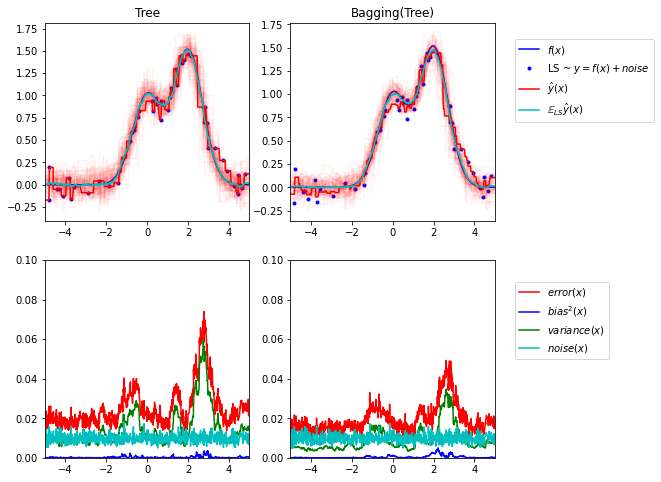

In [26]:
print(__doc__)

# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label="$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

## Пример из scikit learn

In [27]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [28]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [29]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [30]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

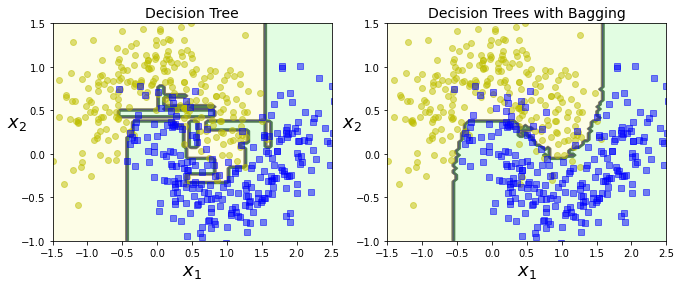

In [31]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

## Random subspace method
Идея брать случайные признаки

Параметры RandomForestRegressor-a:
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [32]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [33]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [34]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [35]:
np.sum(y_pred == y_pred_rf) * 1. / len(y_pred)

0.976

### Ирис

In [36]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [37]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

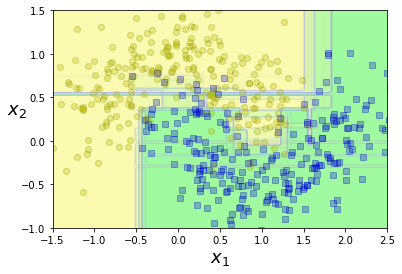

In [38]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

# Важность признаков

In [46]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [47]:
mnist['data'].shape

(70000, 784)

In [49]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(random_state=42)

In [53]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.hot,
            interpolation='nearest')
    plt.axis('off')

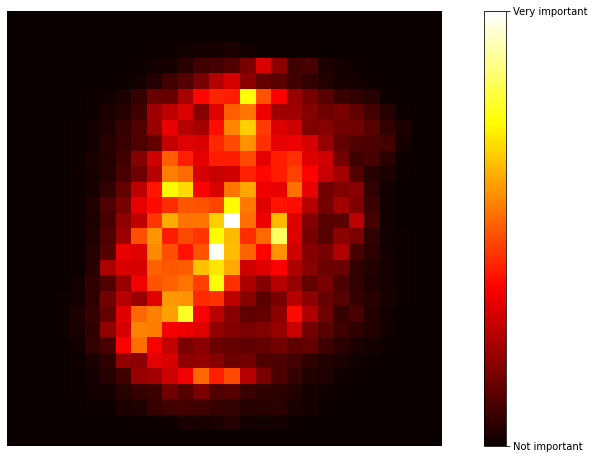

In [55]:
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

# Extremely Randomized Trees
Случайным образом выбирать порог для разюиения в узлах деервьев (случайный набор порогов -> выбираем лучший порог)

In [56]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, Xtest, y_train, y_test = train_test_split(X, y, random_state=42)

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

ex_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
ex_clf.fit(X_train, y_train)

y_pred_ex = ex_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_ex))

0.912
0.912


# Практические замечания

\+ RandomForest во многих задачах является сильным бейзлайном<br>
\+ Хорошо работает на больших выборках (много признаков/много данных)<br>
\+ Не сильно чувствителен к изменению параметров<br>
\+ Не чувствителен к выбросам в данных из-за случайного сэмплирования<br>
\+ Возвращает важности отдельных признаков<br>
\+ Параллелизуется<br>
\+ Не склонен к переобучению<br>

\- плохо работает на разреженных выборках<br>
\- занимает много памяти<br>
\- плохо интерпретируется<br>

# Boosting

* Обучить модель
* Посчитать ошибки
* Учесть ошибки и обучить новую модель
* Повторять некоторое количество раз

Нельзя обучать параллельно

# AdaBoost
Будем влиять на вес тренировочных примеров, участвующих в обучении.
Из этих весов сможем расчитыватьвес модели

In [60]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

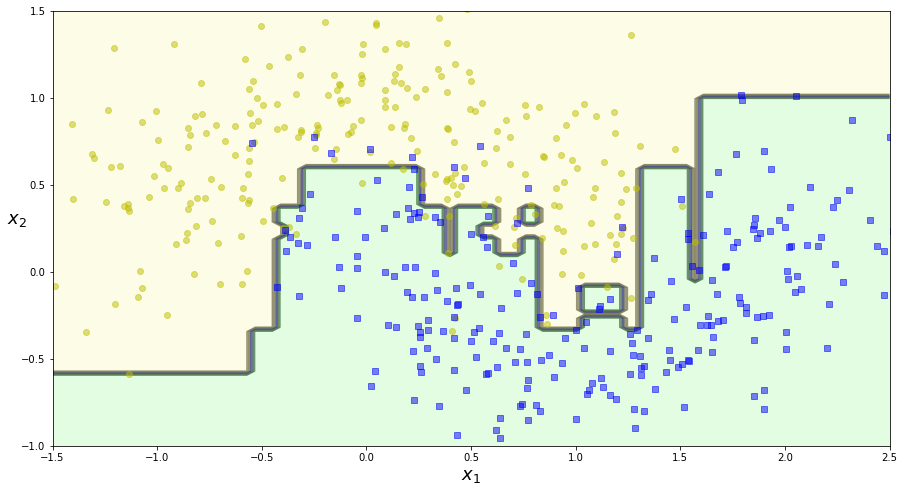

In [61]:
plot_decision_boundary(ada_clf, X, y)

<ipython-input-62-5e96d0e733c9>:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.log((1 - x) / x)
<ipython-input-62-5e96d0e733c9>:2: RuntimeWarning: invalid value encountered in log
  return np.log((1 - x) / x)


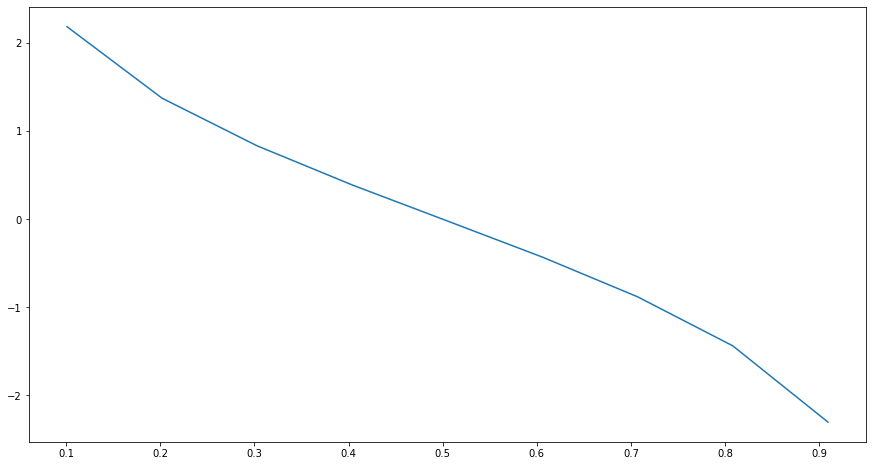

In [62]:
 def f(x):
        return np.log((1 - x) / x)
x = np.linspace(0, 10, 100)
y = f(x)
plt.plot(x, y)

# Stacking, Blending

In [64]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [66]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

X_in, X_out, y_in, y_out = train_test_split(X_train, y_train, random_state=42) # hold-out blending.

In [67]:
svm_clf.fit(X_in, y_in)
rnd_clf.fit(X_in, y_in)

svm_y = svm_clf.predict(X_out)
rnd_y = rnd_clf.predict(X_out)

In [68]:
log_clf.fit(np.c_[svm_y, rnd_y], y_out)

LogisticRegression(random_state=42)

In [69]:
y_stack = log_clf.predict(np.c_[svm_clf.predict(X_test), rnd_clf.predict(X_test)])

In [70]:
accuracy_score(y_test, y_stack)

0.896

In [71]:
accuracy_score(y_test, rnd_clf.predict(X_test))

0.92